AI statement:
"I certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I did not receive any external help, coaching, or contributions
during the production of this work."

### Part I: Exploring Gym Environment

#### Cartpole-v1

In [1]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install -y xvfb x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
!pip install PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install gym
!python -m pip install pyvirtualdisplay
!pip install box2d
!pip install pygame

In [3]:
!pip install tqdm

In [4]:
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display as ipythondisplay

import random

from tqdm import tqdm, trange


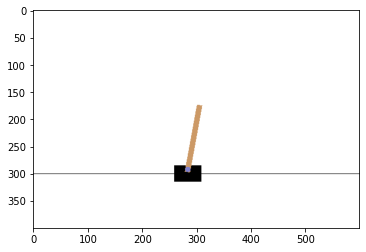

In [5]:
display = Display(visible=False, size=(400, 300))
display.start() 

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Load the gym environment


env = gym.make('CartPole-v1')

# Let's watch how an untrained agent moves around
state = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
for j in range(100):
    action = random.choice(range(2))
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

ipythondisplay.clear_output(wait=True)        
env.close()

Read Environment Properties

In [6]:
''' Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
'''
print(env.action_space)

Discrete(2)


In [7]:
    ''' Observation Space
        The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
        | Num | Observation           | Min                  | Max                |
        |-----|-----------------------|----------------------|--------------------|
        | 0   | Cart Position         | -4.8                 | 4.8                |
        | 1   | Cart Velocity         | -Inf                 | Inf                |
        | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
        | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    '''
    print(env.observation_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


**Rewards**  
    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.<br><br>
**Starting State**  
    All observations are assigned a uniformly random value in `(-0.05, 0.05)`<br><br>
**Episode Termination**  
    The episode terminates if any one of the following occurs:<br>
1.   Pole Angle is greater than ±12°
2.   Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3.   Episode length is greater than 500 (200 for v0)


#### MountainCar-v0

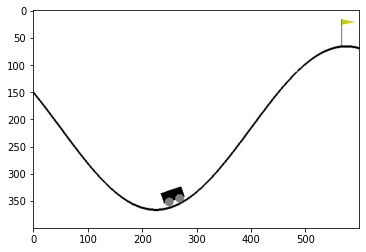

In [8]:
env2 = gym.make('MountainCar-v0')
env2.seed(23)
env2.reset()

# Let's watch how an untrained agent moves around

state = env2.reset()
prev_screen = env2.render(mode='rgb_array')
plt.imshow(prev_screen)
for j in range(100):
#     action = agent.act(state)
    action = random.choice(range(3))
    screen = env2.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = env2.step(action)
    if done:
        break 
        
env2.close()

In [9]:
''' Action Space
    There are 3 discrete deterministic actions:
    | Num | Observation                                                 | Value   | Unit |
    |-----|-------------------------------------------------------------|---------|------|
    | 0   | Accelerate to the left                                      | Inf    | position (m) |
    | 1   | Don't accelerate                                            | Inf  | position (m) |
    | 2   | Accelerate to the right                                     | Inf    | position (m) |
'''
print(env2.action_space)

Discrete(3)


In [10]:
    ''' Observation Space
        The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
        | Num | Observation                                                 | Min                | Max    | Unit |
        |-----|-------------------------------------------------------------|--------------------|--------|------|
        | 0   | position of the car along the x-axis                        | -Inf               | Inf    | position (m) |
        | 1   | velocity of the car                                         | -Inf               | Inf  | position (m) |
    '''
    print(env2.observation_space)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


**Reward**  
    The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep it isn't at the goal and is not penalised (reward = 0) for when it reaches the goal.<br><br>
**Starting State**  
    The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.<br><br>
**Episode Termination**  
The episode terminates if either of the following happens:
1. The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
2. The length of the episode is 200.

### Part II: Implementing DQN & Solving grid-world environment

In [11]:
import gym
from gym import spaces
import pandas as pd
import copy as cp
import math
import numpy as np
import io
from base64 import b64decode, b64encode
from IPython.core.display import display, HTML

In [12]:
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, observation_space, action_space, max_timesteps, stochasticity=1):
    self.observation_space = spaces.Discrete(observation_space)
    self.action_space = spaces.Discrete(action_space)
    self.max_timesteps = max_timesteps
    self.stochasticity = stochasticity

  def set_epsilon(self, epsilon):
    self.epsilon = epsilon

  def reset(self):
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.state = np.zeros((4, 4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    return observation

  def step(self, action):

    if self.stochasticity != 1:
      action = self.get_action_random(action)

    current_pos = cp.deepcopy(self.agent_pos)

    if action == 0: # Go left
      self.agent_pos[0] -= 1
    if action == 1: # Go up
      self.agent_pos[1] -= 1
    if action == 2: # Go right
      self.agent_pos[0] += 1
    if action == 3: # Go down
      self.agent_pos[1] += 1
    
    self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
    future_pos = self.agent_pos
    self.state = np.zeros((4,4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    reward = self.get_reward(current_pos, future_pos)

    self.timestep += 1
    done = True if self.timestep >= self.max_timesteps or self.agent_pos == self.goal_pos else False
    info = {}

    return observation, reward, done, info, action

  # the reward is calculated on the basis of the distance of the
  # current_pos and future_pos of the agent from the goal_pos
  def get_reward(self, current_pos, future_pos):

    current_dist = self.distance_from_goal(current_pos)
    final_dist = self.distance_from_goal(future_pos)

    if final_dist < current_dist:
      return 1
    else:
      return -1
  
  def distance_from_goal(self, pos):
    x_final, y_final = self.goal_pos
    x, y = pos
    return math.sqrt( (y_final - y)**2 + (x_final - x)**2 )

  def get_action_random(self, action):
    if action == 1:
      return 3
    else:
      return action
      

  # https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output
  # https://stackoverflow.com/questions/55562088/open-base64-string-image-in-jupyter-notebook-without-saving
  # https://stackoverflow.com/questions/49015957/how-to-get-python-graph-output-into-html-webpage-directly
  # https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
  def render(self):
    plt.figure()
    # plt.imshow(self.state)
    img = io.BytesIO()
    plt.imsave(img, self.state)
    img.seek(0)
    img_val = img.getvalue()
    # print(img_val)
    encoded_image = b64encode(img_val)
    my_html = '<img height="225px" width="300px" src="data:image/png;base64, {}">'.format(encoded_image.decode('utf-8'))
    display(HTML('<h1>' + my_html + '</h1>'))

The following function returns the action the agent 🤖 will take

In [13]:
stochasticity = 1.0
max_timesteps = 15
observation_space = 16
action_space = 4
max_timesteps = 10

env = GridEnvironment(observation_space, action_space, max_timesteps, stochasticity=1)
obs = env.reset()
env.render()

<Figure size 432x288 with 0 Axes>

In [14]:
def get_action():
    return np.random.choice(env.action_space.n)

def one_hot(x, depth=16):
  return np.take(np.eye(depth), x, axis=0).astype(np.float32)

def get_state_from_position(pos):
    X, Y = env.state.shape
    pos_x, pos_y = pos
    return Y * pos_x + pos_y

In [15]:
import numpy as np
import torch


# l1 = 16 as it will receive the one hot encoded observation space
l1 = 16
l2 = 150
l3 = 100
l4 = 4
model = torch.nn.Sequential(
  torch.nn.Linear(l1, l2),
  torch.nn.ReLU(),
  torch.nn.Linear(l2, l3),
  torch.nn.ReLU(),
  torch.nn.Linear(l3,l4)
)
if torch.cuda.is_available():
  model = model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9

In [16]:
!pip install hiddenlayer

In [17]:
import hiddenlayer as hl

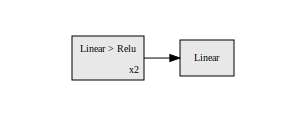

In [18]:
hl.build_graph(model, torch.zeros([1, 16]).cuda())

In [19]:
batch_length = 5

epsilon = 1.0
epochs = 1000
losses = list()
mem_size = 1000 * batch_length                                                            
batch_size = 200 * batch_length                                                                   
# replay = deque(maxlen=mem_size)
replay = np.array(list(), dtype=np.int32)
max_moves = 50                                                                 
h = 0
rate_of_decay = 10**(-8/epochs)
epsilon_list = list()
epsilon_list.append(epsilon)
tot_reward_list = list()


debug = True

t = trange(epochs)

for i in t:
  env.reset()

  completed = False

  loss_ep = list()

  tot_reward = 0

  while not completed:

    current_state = get_state_from_position(env.agent_pos)
    current_state_oh = one_hot(current_state)
    current_state_oh = torch.from_numpy(current_state_oh)
    if torch.cuda.is_available():
        current_state_oh = current_state_oh.cuda()
    qval = model(current_state_oh)                                                   
    qval_ = qval.data.cpu().numpy()

    if (random.random() < epsilon):                                       
      current_action = get_action()
    else:
      current_action = np.argmax(qval_)

    future_state = get_state_from_position(env.agent_pos)
    observation, reward, done, info, action = env.step(current_action)

    tot_reward+=reward
    
    record = np.array([current_state, current_action, reward, future_state, done])
    
    if len(replay) >= mem_size:
      while(len(replay)<mem_size):
        replay = np.delete(replay, replay[0:5], axis=0)
    if len(replay) < mem_size: 
      replay = np.append(replay, record, axis=0)
  

    if len(replay) >= batch_size:
      rng = np.random.default_rng()
      minibatch = np.reshape(replay, (len(replay)// batch_length, batch_length))
      minibatch = rng.choice(minibatch, batch_size)
      
      action_ = list()
      reward_ = list()
      done_ = list()
      state1_ = list()
      state2_ = list()

      for val in minibatch:
        
        state1_.append(one_hot(val[0]))

        action_.append(val[1])
        
        reward_.append(val[2])
        
        state2_.append(one_hot(val[3]))
        
        done_.append(val[4])
        
      
      action_ = np.array(action_)
      reward_ = np.array(reward_)
      done_ = np.array(done_)
      state1_ = np.array(state1_)
      state2_ = np.array(state2_)

      state1_batch = torch.from_numpy(state1_).cuda()
      action_batch = torch.from_numpy(action_).cuda()
      reward_batch = torch.from_numpy(reward_).cuda()
      state2_batch = torch.from_numpy(state2_).cuda()
      done_batch = torch.from_numpy(done_).cuda()
      
      Q1 = model(state1_batch)                                           
      with torch.no_grad():
          Q2 = model(state2_batch)                                      
      
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
      loss = loss_fn(X, Y.detach())
      optimizer.zero_grad()
      loss.backward()
      loss_ep.append(loss.item())
      optimizer.step() 

    completed = True if done else False
  epsilon = epsilon*rate_of_decay
  epsilon_list.append(epsilon)
  tot_reward_list.append(tot_reward)
  if(len(loss_ep)==0):
    losses.append(float('inf'))
  else:
    losses.append(np.average(loss_ep))
  t.set_postfix(loss=np.average(loss_ep))

losses = np.array(losses)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s, loss=1.76]


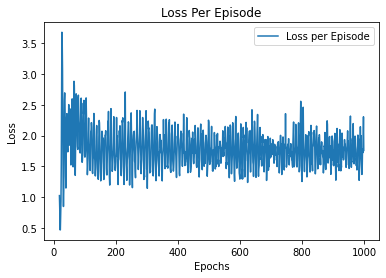

In [20]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

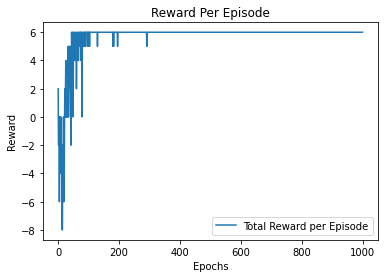

In [21]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

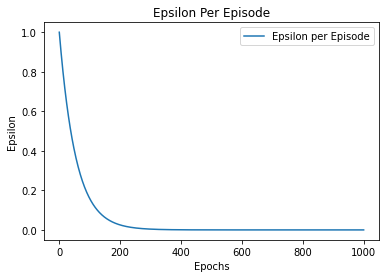

In [22]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

In [23]:
rewards_list = list()

for i in range(10):  
  env.reset()

  completed = False

  reward_list = list()

  tot_reward = 0

  cum_reward = 0

  steps = 0

  loss_ep = list()

  while not completed:

    current_state = get_state_from_position(env.agent_pos)
    current_state_oh = one_hot(current_state)
    current_state_oh = torch.from_numpy(current_state_oh).cuda()
    with torch.no_grad():
      qval = model(current_state_oh)                                                   
    
    qval_ = qval.data.cpu().numpy()
    
    current_action = np.argmax(qval_)

    # future_state = get_state_from_position(env.agent_pos)
    observation, reward, done, info, action = env.step(current_action)

    tot_reward += reward

    cum_reward += pow(gamma, steps)*reward

    reward_list.append([tot_reward, cum_reward])

    steps += 1

    completed = True if done else False

  rewards_list.append(reward_list)

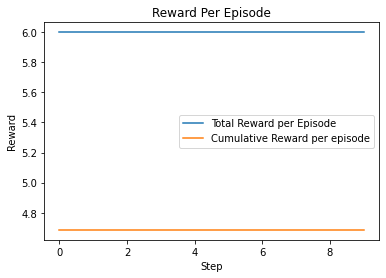

In [24]:
rewards = np.array(rewards_list)

plt.title("Reward Per Episode")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.plot(range(10), rewards[:,  5, 0], label = 'Total Reward per Episode')
plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

# Part III - DQN on OpenAI Gym environments



## a) DQN for CartPole-v1

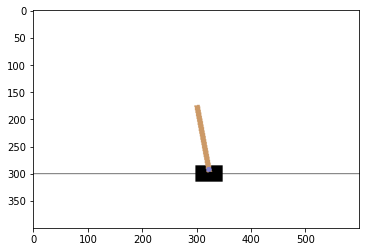

In [25]:
cartpole_env = gym.make('CartPole-v1')

# Let's watch how an untrained agent moves around
state = cartpole_env.reset()
prev_screen = cartpole_env.render(mode='rgb_array')
plt.imshow(prev_screen)
for j in range(100):
    action = random.choice(range(2))
    screen = cartpole_env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = cartpole_env.step(action)
    if done:
        break 

ipythondisplay.clear_output(wait=True)        
cartpole_env.close()

## b) DQN for Atari Breakout

In [26]:
#ROMS credit - http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html

!python -m atari_py.import_roms .

copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

In [27]:
#Instatntiate gym Atari-Breakout environment
breakout_env = gym.make("Breakout-v0")
breakout_env.reset()
n_actions = breakout_env.action_space.n
state_dim = breakout_env.observation_space.shape

In [28]:
print(f'Action Space: {n_actions}\nObservation Space Dimenions: {state_dim}')

Action Space: 4
Observation Space Dimenions: (210, 160, 3)


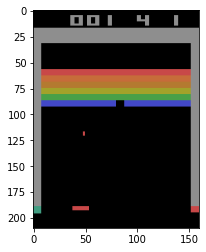

In [29]:
state = breakout_env.reset()
prev_screen = breakout_env.render(mode='rgb_array')
plt.imshow(prev_screen)
for j in range(100):
#     action = agent.act(state)
    action = random.choice(range(n_actions))
    screen = breakout_env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = breakout_env.step(action)
    if done:
        break 
        
breakout_env.close()